In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [4]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [8]:
from plaid.evaluation import parmar_kid, parmar_fid, sinkhorn, ConditionalDistributionDistance

In [6]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [7]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

In [9]:
sinkhorn(gt_x1, gt_x2)

0.09390160464681685

### Unconditional to Random

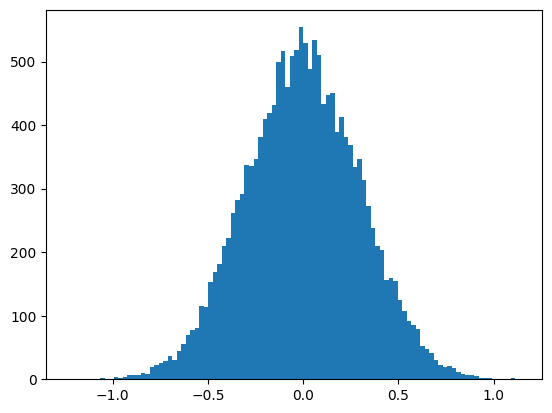

In [10]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)

random_arr = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random_arr.flatten(), bins=100)

In [11]:
random_fid = parmar_fid(random_arr, gt_x1)
print(random_fid)

3.64562124110458


In [12]:
parmar_fid(random_arr, gt_x2)

3.6613143722900707

In [13]:
sinkhorn(random_arr, gt_x2)

4.330964043618719

# Unconditional generation performance

# Amass Conditional FID

In [14]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 29.87 seconds


In [17]:
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1")

In [19]:
def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])

condgen_to_true = {}
uncond_to_true = {}

batch_size = 128
metric = "sinkhorn"

for i, cond_code in enumerate(os.listdir(samples_dir)):
    function_idx, organism_idx = cond_code_to_idx(cond_code)
    # timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
    timestamps = os.listdir(samples_dir / cond_code)
    
    if len(timestamps) > 0:
        try:
            timestamp = timestamps[-1]
            fpath = samples_dir / cond_code / timestamp / "latent.npz"
            print(fpath)
    
            cond_fid = ConditionalDistributionDistance(
                function_idx=function_idx,
                organism_idx=organism_idx,
                cheap_pipeline=cheap_pipeline,
                batch_size=batch_size,
                max_seq_len=256,
                max_eval_samples=256,
                min_samples=16,
                metric=metric
            )
            
            with np.load(fpath, allow_pickle=True) as f:
                x = f['samples'].astype(np.float32)
    
            feat = x[:, -1, :, :] # take last timestep only
            feat = feat.mean(axis=1)
            res = cond_fid.run(feat)
            print(cond_code, f"Generated <-> GT {metric}:", res)
    
            condgen_to_true[cond_code] = res
    
            # also try what happens if you do ground truth unconditional to conditional
            # res = parmar_fid(feat, gt_x1)
            res = parmar_fid(cond_fid.real, gt_x1)
            uncond_to_true[cond_code] = res
            print(cond_code, f"Random Real <-> GT {metric}:", res)
        except Exception as e:
            print(e)
            continue
            
    else:
        pass

/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1/f515_o3617/240919_0647/latent.npz
Found 11147 samples for this condition.
f515_o3617 Generated <-> GT sinkhorn: 0.6837414433248341
f515_o3617 Random Real <-> GT sinkhorn: 0.311377208688856
/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1/f682_o3617/240920_0025/latent.npz
Found 1861 samples for this condition.
f682_o3617 Generated <-> GT sinkhorn: 0.6108929123729467
f682_o3617 Random Real <-> GT sinkhorn: 0.3079041575805799
/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1/f652_o3617/240919_2045/latent.npz
Found 6860 samples for this condition.
f652_o3617 Generated <-> GT sinkhorn: 0.6779369814321399
f652_o3617 Random Real <-> GT sinkhorn: 0.4111807267128428
/data/lux70/plaid/artifacts/samples/5j007z42/function_cond/v1/f606_o3617/240919_1140/latent.npz
Found 1162 samples for this condition.
f606_o3617 Generated <-> GT sinkhorn: 0.3697053259238601
f606_o3617 Random Real <-> GT sinkhorn: 0.2751938561953

# Plot

In [21]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)
combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [22]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
0,f515_o3617,0.683741,0.311377,515,3617,390,alanyl-tRNA aminoacylation,PF01411,GO:0006419,process,1,0.372364
2,f652_o3617,0.677937,0.411181,652,3617,1031,intracellular manganese ion homeostasis,PF01988,GO:0030026,process,1,0.266756
6,f227_o3617,0.262485,0.541907,227,3617,1253,monoatomic cation channel activity,PF00558,GO:0005261,function,1,-0.279423
7,f1506_o3617,0.785824,0.521661,1506,3617,534,carbohydrate transmembrane transporter activity,PF06800,GO:0015144,function,1,0.264164
15,f352_o3617,0.615567,0.376417,352,3617,1761,recognition of pollen,PF00954,GO:0048544,process,1,0.239151
26,f2181_o3617,0.193608,0.327694,2181,3617,1484,"phosphatidylinositol 3-kinase complex, class I...",PF17649,GO:0034272,component,1,-0.134086
27,f1161_o3617,0.419193,0.227990,1161,3617,2048,thiamine diphosphokinase activity,PF04263,GO:0004788,function,1,0.191202
21,f1800_o3617,0.751670,0.511811,1800,3617,2050,thiamine transmembrane transporter activity,PF09515,GO:0015234,function,1,0.239859
58,f220_o3617,0.208318,0.622653,220,3617,272,RNA-binding transcription regulator activity,PF00539,GO:0001070,function,1,-0.414335
49,f655_o3617,0.440664,0.304241,655,3617,2022,tRNA nucleoside ribose methylation,PF01994,GO:0002128,process,1,0.136423


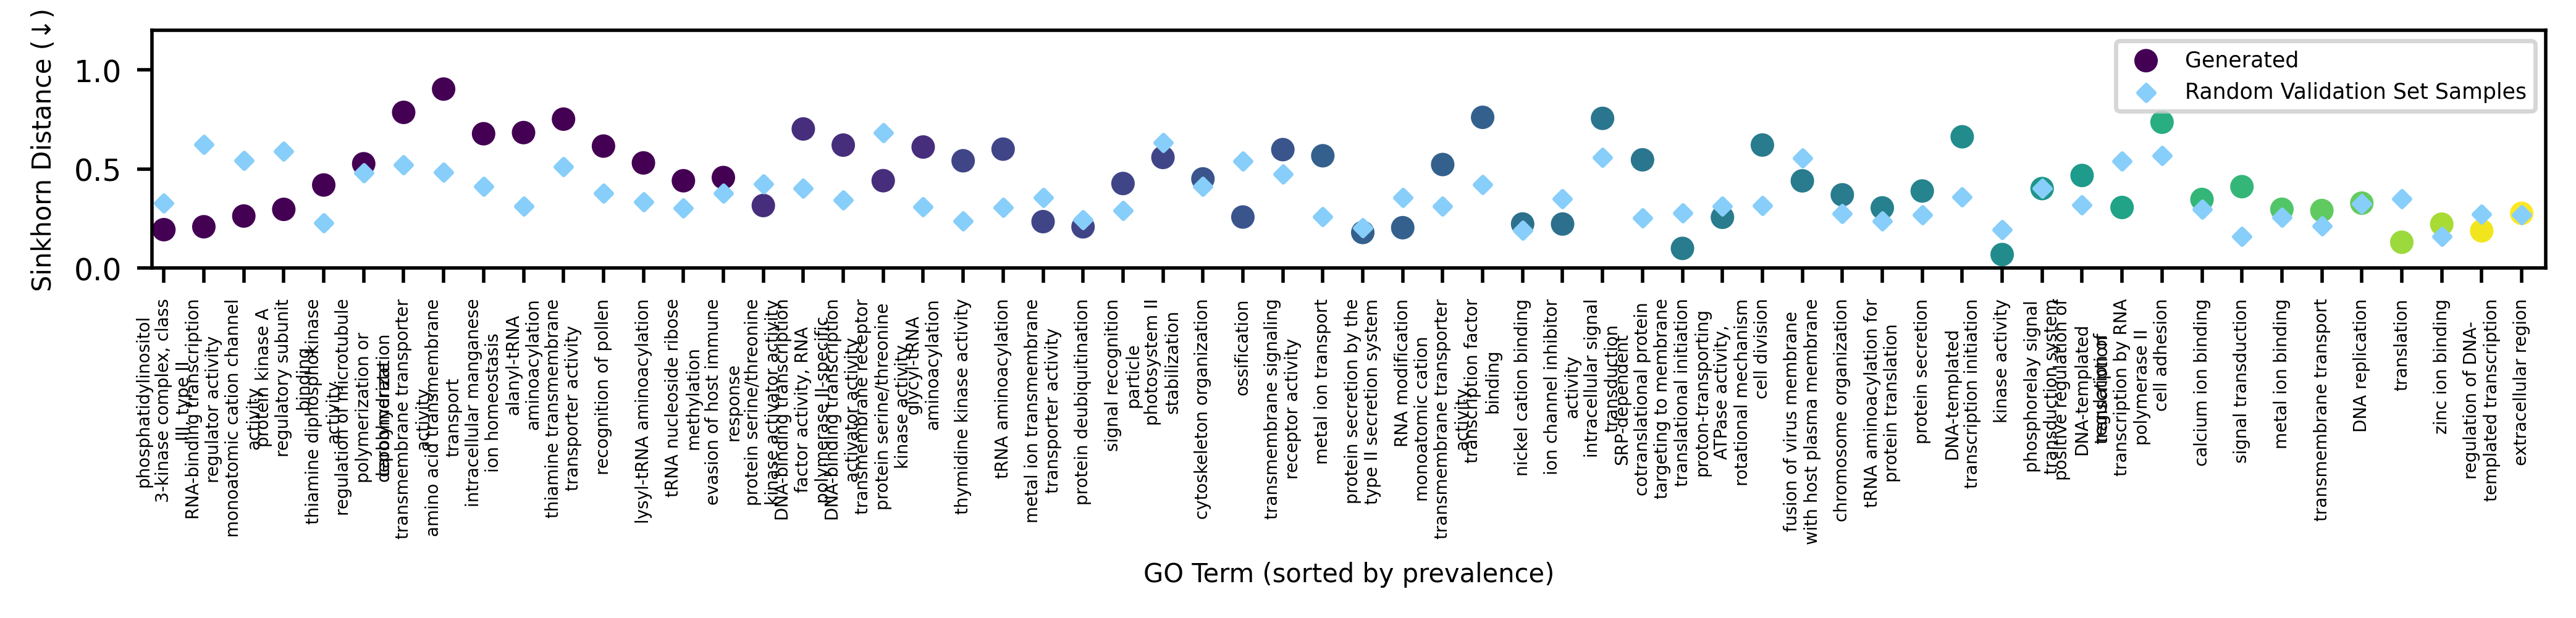

In [36]:
import textwrap
plt.rcParams['font.size'] = 7

from matplotlib import cm
from matplotlib.colors import Normalize

values = np.log(combined_df['count'])
norm = Normalize(vmin=min(values), vmax=max(values))

combined_df = combined_df.sort_values(by="condgen_to_true")
combined_df = combined_df.sort_values(by="count")

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=500, figsize=(10,1))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=20, c=colors)
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=7, c="lightskyblue", marker="D")

ax.set_xlim(-0.3, len(combined_df) - 0.4)

x_labels = combined_df.GO_term.values
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in x_labels]

ax.set_xticks(ticks=np.arange(len(combined_df)), labels=wrapped_labels, rotation=90, fontsize=4)

# ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
# ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,1.2)
ax.set_xlabel("GO Term (sorted by prevalence)", fontsize=6)
ax.set_ylabel("Sinkhorn Distance (↓)", fontsize=6)

plt.legend(fontsize=5)

In [26]:
print(combined_df[combined_df.delta < 0.].GO_term.values)
print(combined_df[combined_df.delta < 0.].GO_idx.values)

['phosphatidylinositol 3-kinase complex, class III, type II'
 'RNA-binding transcription regulator activity'
 'monoatomic cation channel activity'
 'protein kinase A regulatory subunit binding'
 'protein serine/threonine kinase activator activity'
 'transmembrane receptor protein serine/threonine kinase activity'
 'metal ion transmembrane transporter activity' 'protein deubiquitination'
 'photosystem II stabilization' 'ossification'
 'protein secretion by the type II secretion system' 'RNA modification'
 'ion channel inhibitor activity' 'translational initiation'
 'proton-transporting ATPase activity, rotational mechanism'
 'fusion of virus membrane with host plasma membrane' 'kinase activity'
 'phosphorelay signal transduction system'
 'regulation of transcription by RNA polymerase II' 'translation'
 'regulation of DNA-templated transcription']
[2181  220  227 2046  622  382  547  192  599  323  434  319  197  269
  617  215  169   29  427   83   86]


In [63]:
# combined_df.to_csv("~/cond_fid_tmp2.csv", sep=",")